In [1]:
import numpy as np
import torch
from torch import nn
import tqdm
import torch.optim as optim

In [2]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [3]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


# Use the following code to create a validation set of 10%
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


#Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")



# Sample code to plot N^2 images from the dataset
# def plot_images(XX, N, title):
#     fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
#     for i in range(N):
#       for j in range(N):
#         ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
#         ax[i,j].axis("off")
#     fig.suptitle(title, fontsize=24)

# plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

    

100%|██████████| 26.4M/26.4M [00:43<00:00, 614kB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:06<00:00, 662kB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.98MB/s]

106
12
40


In [59]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden_layers): 
        super(ACAIGFCN, self).__init__()
        layers = []
        
        # Input Layer
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.ReLU())
        
        # Hidden Layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(nn.ReLU())
        
        # Output Layer
        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [109]:
def train_and_validate(model, loss_func, optimizer, epochs):
    train_loss_list = np.zeros((epochs,))
    val_accuracy_list = np.zeros((epochs,))

    # Training and validation loop
    for epoch in tqdm.trange(epochs):
        # ACAIGFCN Training
        model.train()  # Set model to training mode
        epoch_loss = 0
        for train_features, train_labels in train_batches:
            # Reshape images into vectors
            train_features = train_features.view(-1, 784)
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(train_features)
            loss = loss_func(outputs, train_labels)  # Calculate training loss
            
            # Backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            epoch_loss += loss.item()

        # Record average loss for the epoch
        train_loss_list[epoch] = epoch_loss / len(train_batches)

        # ACAIGFCN Validation
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():  # No gradients needed
            for val_features, val_labels in val_batches:
                # Reshape validation images into vectors
                val_features = val_features.view(-1, 784)
                
                # Compute validation outputs
                outputs = model(val_features)
                _, predicted = torch.max(outputs, 1)  # Get predictions
                
                # Compute accuracy
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        val_acc = correct / total
        val_accuracy_list[epoch] = val_acc * 100  # Store validation accuracy

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss_list[epoch]:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")
    
    return train_loss_list, val_accuracy_list

In [63]:
def calculate_test_accuracy(model):
    # Calculate accuracy on test set
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        
        batch_accuracies = []  # To store accuracy for each batch
        
        for test_features, test_labels in test_batches:
            # Reshape test images into a vector (flatten)
            test_features = test_features.view(-1, 28 * 28)
            
            # Compute model outputs
            outputs = model(test_features)
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            
            # Compute accuracy for the batch
            correct = (predicted == test_labels).sum().item()
            accuracy = correct / test_labels.size(0)  # Batch accuracy
            batch_accuracies.append(accuracy)

        # Compute total (mean) accuracy
        mean_accuracy = np.mean(batch_accuracies) * 100  # Convert to percentage
        std_accuracy = np.std(batch_accuracies) * 100    # Standard deviation of accuracy (percentage)

    # Report total (mean) accuracy and standard deviation
    print(f"Mean Accuracy on Test Set: {mean_accuracy:.2f}%")
    print(f"Standard Deviation of Accuracy Across Batches: {std_accuracy:.2f}%")

  2%|▏         | 1/50 [00:02<02:13,  2.72s/it]

Epoch [1/50], Loss: 0.9054, Validation Accuracy: 74.97%


  4%|▍         | 2/50 [00:05<02:09,  2.69s/it]

Epoch [2/50], Loss: 0.5456, Validation Accuracy: 80.22%


  6%|▌         | 3/50 [00:07<02:04,  2.65s/it]

Epoch [3/50], Loss: 0.4658, Validation Accuracy: 83.37%


  8%|▊         | 4/50 [00:10<02:04,  2.70s/it]

Epoch [4/50], Loss: 0.4268, Validation Accuracy: 82.03%


 10%|█         | 5/50 [00:13<01:59,  2.66s/it]

Epoch [5/50], Loss: 0.4015, Validation Accuracy: 85.37%


 12%|█▏        | 6/50 [00:15<01:56,  2.65s/it]

Epoch [6/50], Loss: 0.3842, Validation Accuracy: 83.93%


 14%|█▍        | 7/50 [00:18<01:51,  2.60s/it]

Epoch [7/50], Loss: 0.3684, Validation Accuracy: 86.25%


 16%|█▌        | 8/50 [00:20<01:47,  2.57s/it]

Epoch [8/50], Loss: 0.3572, Validation Accuracy: 85.15%


 18%|█▊        | 9/50 [00:23<01:44,  2.55s/it]

Epoch [9/50], Loss: 0.3415, Validation Accuracy: 86.98%


 20%|██        | 10/50 [00:26<01:42,  2.55s/it]

Epoch [10/50], Loss: 0.3360, Validation Accuracy: 86.73%


 22%|██▏       | 11/50 [00:28<01:38,  2.54s/it]

Epoch [11/50], Loss: 0.3226, Validation Accuracy: 86.37%


 24%|██▍       | 12/50 [00:31<01:36,  2.54s/it]

Epoch [12/50], Loss: 0.3153, Validation Accuracy: 87.90%


 26%|██▌       | 13/50 [00:33<01:35,  2.59s/it]

Epoch [13/50], Loss: 0.3067, Validation Accuracy: 87.65%


 28%|██▊       | 14/50 [00:36<01:32,  2.57s/it]

Epoch [14/50], Loss: 0.3014, Validation Accuracy: 86.98%


 30%|███       | 15/50 [00:38<01:29,  2.56s/it]

Epoch [15/50], Loss: 0.2935, Validation Accuracy: 88.52%


 32%|███▏      | 16/50 [00:41<01:26,  2.54s/it]

Epoch [16/50], Loss: 0.2841, Validation Accuracy: 88.83%


 34%|███▍      | 17/50 [00:43<01:23,  2.53s/it]

Epoch [17/50], Loss: 0.2809, Validation Accuracy: 88.82%


 36%|███▌      | 18/50 [00:46<01:21,  2.55s/it]

Epoch [18/50], Loss: 0.2756, Validation Accuracy: 87.68%


 38%|███▊      | 19/50 [00:49<01:19,  2.57s/it]

Epoch [19/50], Loss: 0.2716, Validation Accuracy: 86.33%


 40%|████      | 20/50 [00:51<01:16,  2.56s/it]

Epoch [20/50], Loss: 0.2664, Validation Accuracy: 87.48%


 42%|████▏     | 21/50 [00:54<01:14,  2.56s/it]

Epoch [21/50], Loss: 0.2579, Validation Accuracy: 89.08%


 44%|████▍     | 22/50 [00:56<01:11,  2.55s/it]

Epoch [22/50], Loss: 0.2556, Validation Accuracy: 86.97%


 46%|████▌     | 23/50 [00:59<01:08,  2.53s/it]

Epoch [23/50], Loss: 0.2492, Validation Accuracy: 88.43%


 48%|████▊     | 24/50 [01:01<01:05,  2.54s/it]

Epoch [24/50], Loss: 0.2449, Validation Accuracy: 88.03%


 50%|█████     | 25/50 [01:04<01:03,  2.52s/it]

Epoch [25/50], Loss: 0.2407, Validation Accuracy: 89.35%


 52%|█████▏    | 26/50 [01:06<01:00,  2.51s/it]

Epoch [26/50], Loss: 0.2368, Validation Accuracy: 89.00%


 54%|█████▍    | 27/50 [01:09<00:58,  2.56s/it]

Epoch [27/50], Loss: 0.2322, Validation Accuracy: 88.15%


 56%|█████▌    | 28/50 [01:11<00:55,  2.54s/it]

Epoch [28/50], Loss: 0.2260, Validation Accuracy: 89.38%


 58%|█████▊    | 29/50 [01:14<00:53,  2.53s/it]

Epoch [29/50], Loss: 0.2315, Validation Accuracy: 88.72%


 60%|██████    | 30/50 [01:16<00:50,  2.53s/it]

Epoch [30/50], Loss: 0.2234, Validation Accuracy: 88.38%


 62%|██████▏   | 31/50 [01:19<00:47,  2.52s/it]

Epoch [31/50], Loss: 0.2183, Validation Accuracy: 89.88%


 64%|██████▍   | 32/50 [01:21<00:45,  2.52s/it]

Epoch [32/50], Loss: 0.2149, Validation Accuracy: 89.37%


 66%|██████▌   | 33/50 [01:24<00:43,  2.53s/it]

Epoch [33/50], Loss: 0.2124, Validation Accuracy: 88.78%


 68%|██████▊   | 34/50 [01:27<00:40,  2.53s/it]

Epoch [34/50], Loss: 0.2116, Validation Accuracy: 90.13%


 70%|███████   | 35/50 [01:29<00:37,  2.51s/it]

Epoch [35/50], Loss: 0.2051, Validation Accuracy: 86.28%


 72%|███████▏  | 36/50 [01:32<00:35,  2.51s/it]

Epoch [36/50], Loss: 0.2044, Validation Accuracy: 86.67%


 74%|███████▍  | 37/50 [01:34<00:32,  2.53s/it]

Epoch [37/50], Loss: 0.1980, Validation Accuracy: 90.23%


 76%|███████▌  | 38/50 [01:37<00:30,  2.52s/it]

Epoch [38/50], Loss: 0.1941, Validation Accuracy: 89.10%


 78%|███████▊  | 39/50 [01:39<00:27,  2.52s/it]

Epoch [39/50], Loss: 0.1921, Validation Accuracy: 88.53%


 80%|████████  | 40/50 [01:42<00:25,  2.53s/it]

Epoch [40/50], Loss: 0.1893, Validation Accuracy: 88.40%


 82%|████████▏ | 41/50 [01:44<00:22,  2.55s/it]

Epoch [41/50], Loss: 0.1876, Validation Accuracy: 89.28%


 84%|████████▍ | 42/50 [01:47<00:20,  2.55s/it]

Epoch [42/50], Loss: 0.1841, Validation Accuracy: 89.82%


 86%|████████▌ | 43/50 [01:49<00:18,  2.59s/it]

Epoch [43/50], Loss: 0.1831, Validation Accuracy: 89.78%


 88%|████████▊ | 44/50 [01:52<00:15,  2.57s/it]

Epoch [44/50], Loss: 0.1757, Validation Accuracy: 89.08%


 90%|█████████ | 45/50 [01:55<00:12,  2.58s/it]

Epoch [45/50], Loss: 0.1826, Validation Accuracy: 88.87%


 92%|█████████▏| 46/50 [01:57<00:10,  2.63s/it]

Epoch [46/50], Loss: 0.1716, Validation Accuracy: 89.08%


 94%|█████████▍| 47/50 [02:00<00:08,  2.67s/it]

Epoch [47/50], Loss: 0.1714, Validation Accuracy: 89.45%


 96%|█████████▌| 48/50 [02:03<00:05,  2.65s/it]

Epoch [48/50], Loss: 0.1704, Validation Accuracy: 88.85%


 98%|█████████▊| 49/50 [02:06<00:02,  2.71s/it]

Epoch [49/50], Loss: 0.1658, Validation Accuracy: 90.27%


100%|██████████| 50/50 [02:09<00:00,  2.58s/it]

Epoch [50/50], Loss: 0.1623, Validation Accuracy: 88.90%


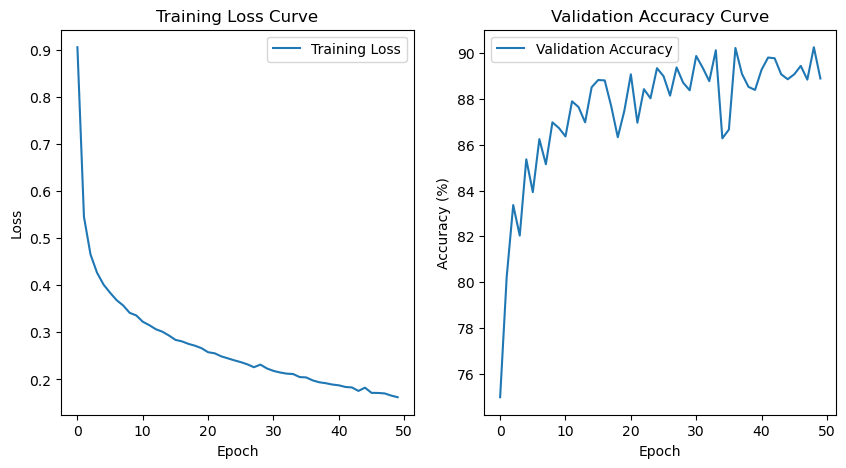

In [110]:
# Define model parameters
input_dim = 784
output_dim = 10
hidden_layers = [256, 128]
epochs = 50
learning_rate = 0.1

# Initialize model, loss function, and optimizer
model = ACAIGFCN(input_dim, output_dim, hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and validate
train_loss, val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("Baseline_Config.pdf")

In [111]:
calculate_test_accuracy(model)

Mean Accuracy on Test Set: 87.35%
Standard Deviation of Accuracy Across Batches: 3.01%


In [75]:
def train_and_validate(model, loss_func, optimizer, epochs):
    train_loss_list = np.zeros((epochs,))
    val_accuracy_list = np.zeros((epochs,))

    # Training and validation loop
    for epoch in tqdm.trange(epochs):
        # ACAIGFCN Training
        model.train()  # Set model to training mode
        epoch_loss = 0
        for train_features, train_labels in train_batches:
            # Reshape images into vectors
            train_features = train_features.view(-1, 784)
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(train_features)
            loss = loss_func(outputs, train_labels)  # Calculate training loss
            
            # Backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            epoch_loss += loss.item()

        # Record average loss for the epoch
        train_loss_list[epoch] = epoch_loss / len(train_batches)

        # ACAIGFCN Validation
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():  # No gradients needed
            for val_features, val_labels in val_batches:
                # Reshape validation images into vectors
                val_features = val_features.view(-1, 784)
                
                # Compute validation outputs
                outputs = model(val_features)
                _, predicted = torch.max(outputs, 1)  # Get predictions
                
                # Compute accuracy
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        val_acc = correct / total
        val_accuracy_list[epoch] = val_acc * 100  # Store validation accuracy
    
    return train_loss_list, val_accuracy_list

In [79]:
# Define optimizers to compare
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSProp': optim.RMSprop
}

learning_rates = [0.001, 0.01, 0.05]
epochs = 20

# Run optimizer comparison
results = {}
for opt_name, opt_fn in optimizers.items():
    for lr in learning_rates:
        print(f"\nOptimizer: {opt_name}, Learning Rate: {lr}")
        model = ACAIGFCN(input_dim, output_dim, hidden_layers)
        optimizer = opt_fn(model.parameters(), lr=lr)

        train_loss, val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)
        test_accuracy = calculate_test_accuracy(model)

        # Store results
        results[f"{opt_name}_lr_{lr}"] = {
            'train_loss': train_loss,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy}


Optimizer: SGD, Learning Rate: 0.001


100%|██████████| 20/20 [00:54<00:00,  2.73s/it]


Mean Accuracy on Test Set: 68.99%
Standard Deviation of Accuracy Across Batches: 3.28%

Optimizer: SGD, Learning Rate: 0.01


100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


Mean Accuracy on Test Set: 82.72%
Standard Deviation of Accuracy Across Batches: 2.02%

Optimizer: SGD, Learning Rate: 0.05


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Mean Accuracy on Test Set: 86.61%
Standard Deviation of Accuracy Across Batches: 1.86%

Optimizer: Adam, Learning Rate: 0.001


100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


Mean Accuracy on Test Set: 89.12%
Standard Deviation of Accuracy Across Batches: 2.02%

Optimizer: Adam, Learning Rate: 0.01


100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


Mean Accuracy on Test Set: 86.62%
Standard Deviation of Accuracy Across Batches: 1.85%

Optimizer: Adam, Learning Rate: 0.05


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]


Mean Accuracy on Test Set: 83.36%
Standard Deviation of Accuracy Across Batches: 2.98%

Optimizer: RMSProp, Learning Rate: 0.001


100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


Mean Accuracy on Test Set: 87.37%
Standard Deviation of Accuracy Across Batches: 2.34%

Optimizer: RMSProp, Learning Rate: 0.01


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Mean Accuracy on Test Set: 84.73%
Standard Deviation of Accuracy Across Batches: 2.04%

Optimizer: RMSProp, Learning Rate: 0.05


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]


Mean Accuracy on Test Set: 12.50%
Standard Deviation of Accuracy Across Batches: 2.13%


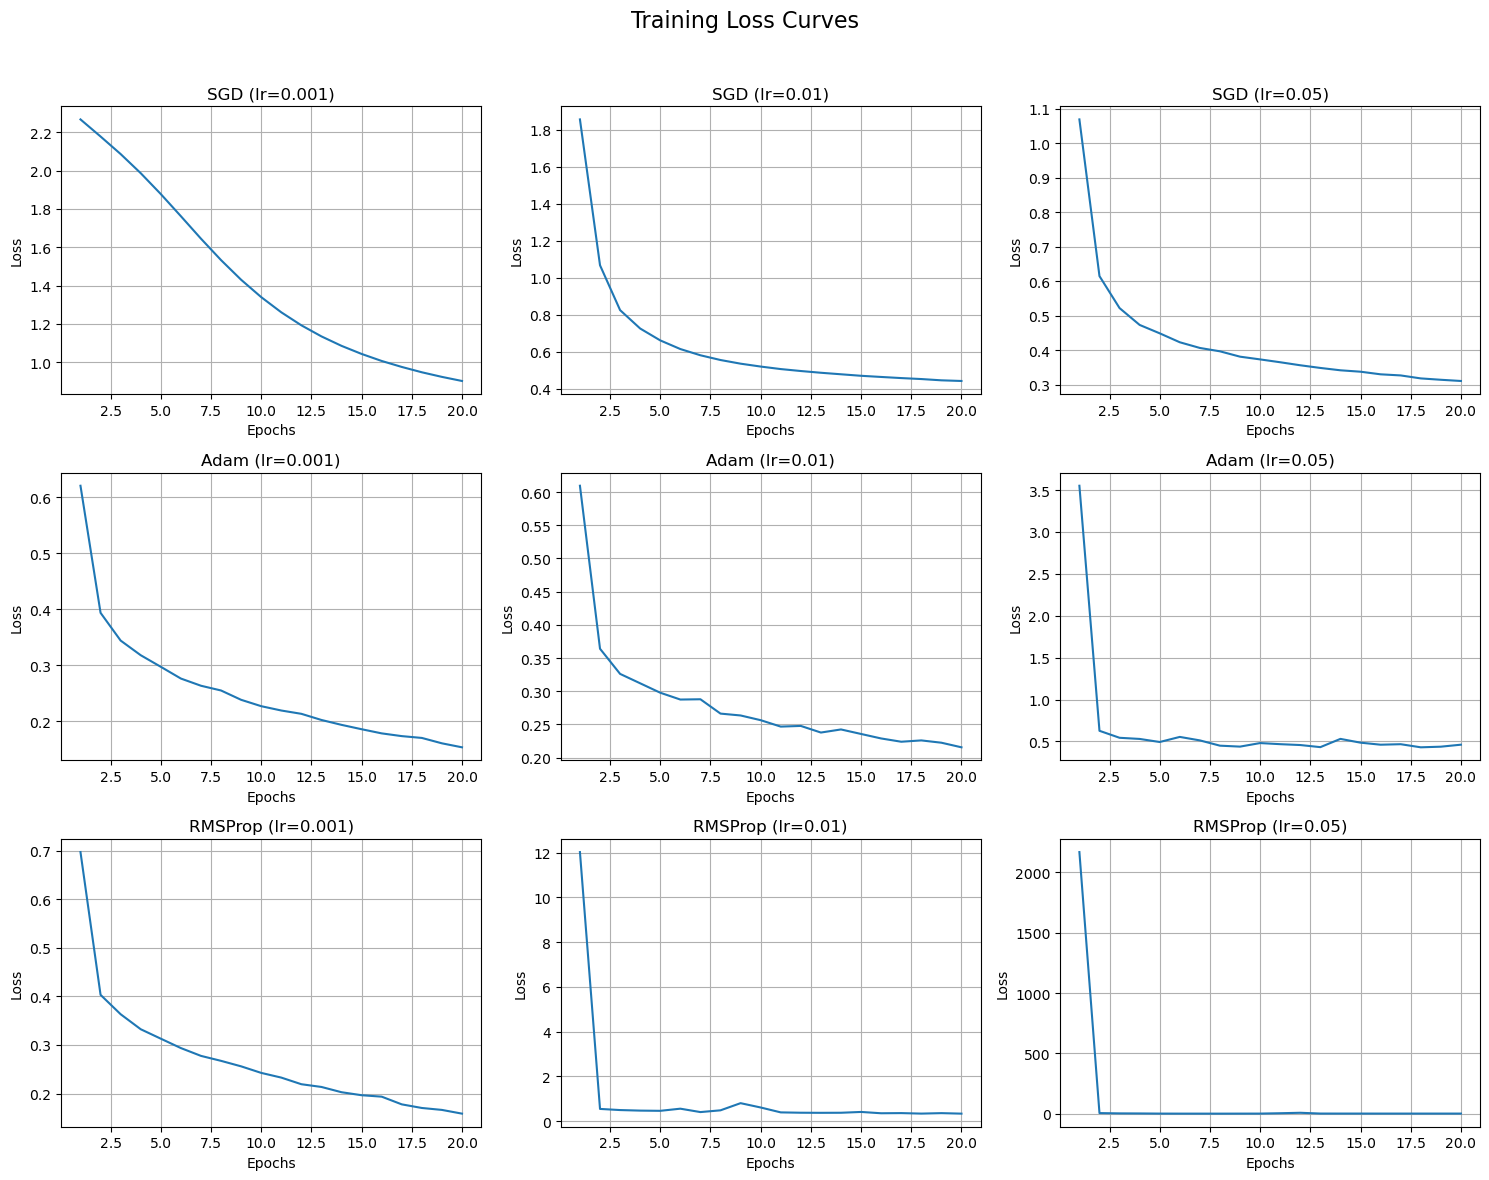

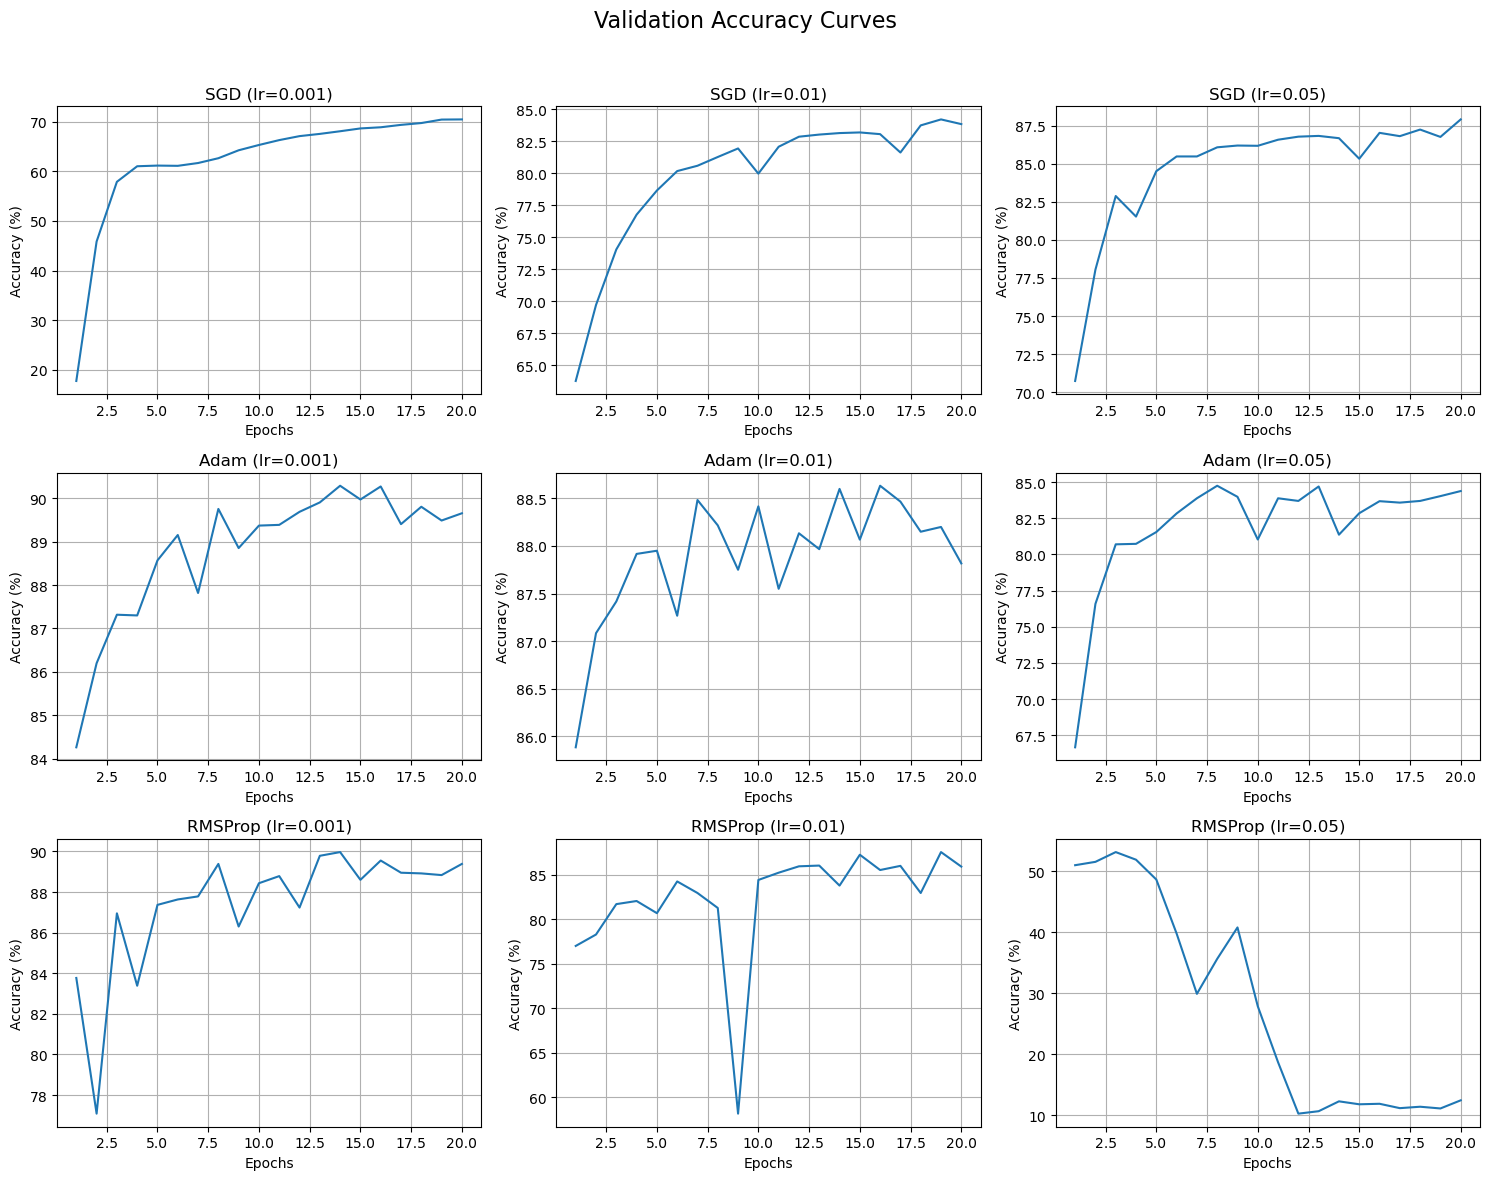

In [82]:
# Create 9 subplots for Training Loss
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Training Loss Curves", fontsize=16)
axes = axes.ravel()  # Flatten the 3x3 grid into a 1D array for easier indexing

for i, opt_name in enumerate(optimizers):
    for j, lr in enumerate(learning_rates):
        key = f"{opt_name}_lr_{lr}"
        index = i * 3 + j  # Flattened index for subplot
        if key in results:
            train_loss = results[key]['train_loss']
            axes[index].plot(range(1, len(train_loss) + 1), train_loss)
            axes[index].set_title(f"{opt_name} (lr={lr})")
            axes[index].set_xlabel("Epochs")
            axes[index].set_ylabel("Loss")
            axes[index].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.savefig("Training_Loss_Curves.pdf")  # Save the figure as a PDF
plt.show()

# Create 9 subplots for Validation Accuracy
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Validation Accuracy Curves", fontsize=16)
axes = axes.ravel()  # Flatten the 3x3 grid into a 1D array for easier indexing

for i, opt_name in enumerate(optimizers):
    for j, lr in enumerate(learning_rates):
        key = f"{opt_name}_lr_{lr}"
        index = i * 3 + j  # Flattened index for subplot
        if key in results:
            val_accuracy = results[key]['val_accuracy']
            axes[index].plot(range(1, len(val_accuracy) + 1), val_accuracy)
            axes[index].set_title(f"{opt_name} (lr={lr})")
            axes[index].set_xlabel("Epochs")
            axes[index].set_ylabel("Accuracy (%)")
            axes[index].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.savefig("Validation_Accuracy_Curves.pdf")  # Save the figure as a PDF
plt.show()

In [84]:
class ACAIGFCNWithDropout(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout_prob=0.5):
        super(ACAIGFCNWithDropout, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

100%|██████████| 50/50 [02:18<00:00,  2.77s/it]


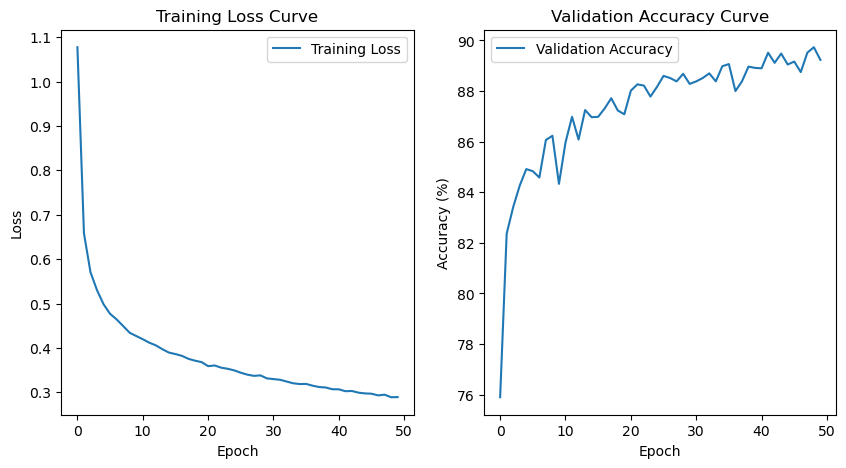

In [108]:
# Define model parameters
input_dim = 784
output_dim = 10
hidden_layers = [256, 128]
epochs = 50
learning_rate = 0.1

# Initialize model, loss function, and optimizer
model = ACAIGFCNWithDropout(input_dim, output_dim, hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and validate
train_loss, val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("Dropout_Reg.pdf")

plt.show()

In [86]:
calculate_test_accuracy(model)

Mean Accuracy on Test Set: 88.59%
Standard Deviation of Accuracy Across Batches: 2.12%


In [88]:
def initialize_weights(model, init_type):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if init_type == 'random_normal':
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(layer.weight)
            elif init_type == 'kaiming':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')

In [93]:
# Define model parameters
input_dim = 784
output_dim = 10
hidden_layers = [256, 128]
epochs = 50
learning_rate = 0.1

# Initialize model, loss function, and optimizer
model = ACAIGFCN(input_dim, output_dim, hidden_layers)
initialize_weights(model, "random_normal")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and validate
rn_train_loss, rn_val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)
calculate_test_accuracy(model)

100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


Mean Accuracy on Test Set: 86.89%
Standard Deviation of Accuracy Across Batches: 2.08%


In [94]:
# Initialize model, loss function, and optimizer
model = ACAIGFCN(input_dim, output_dim, hidden_layers)
initialize_weights(model, "xavier")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and validate
xavier_train_loss, xavier_val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)
calculate_test_accuracy(model)

100%|██████████| 50/50 [02:17<00:00,  2.74s/it]


Mean Accuracy on Test Set: 88.54%
Standard Deviation of Accuracy Across Batches: 2.05%


In [95]:
# Initialize model, loss function, and optimizer
model = ACAIGFCN(input_dim, output_dim, hidden_layers)
initialize_weights(model, "kaiming")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and validate
kaiming_train_loss, kaiming_val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)
calculate_test_accuracy(model)

100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


Mean Accuracy on Test Set: 87.37%
Standard Deviation of Accuracy Across Batches: 2.23%


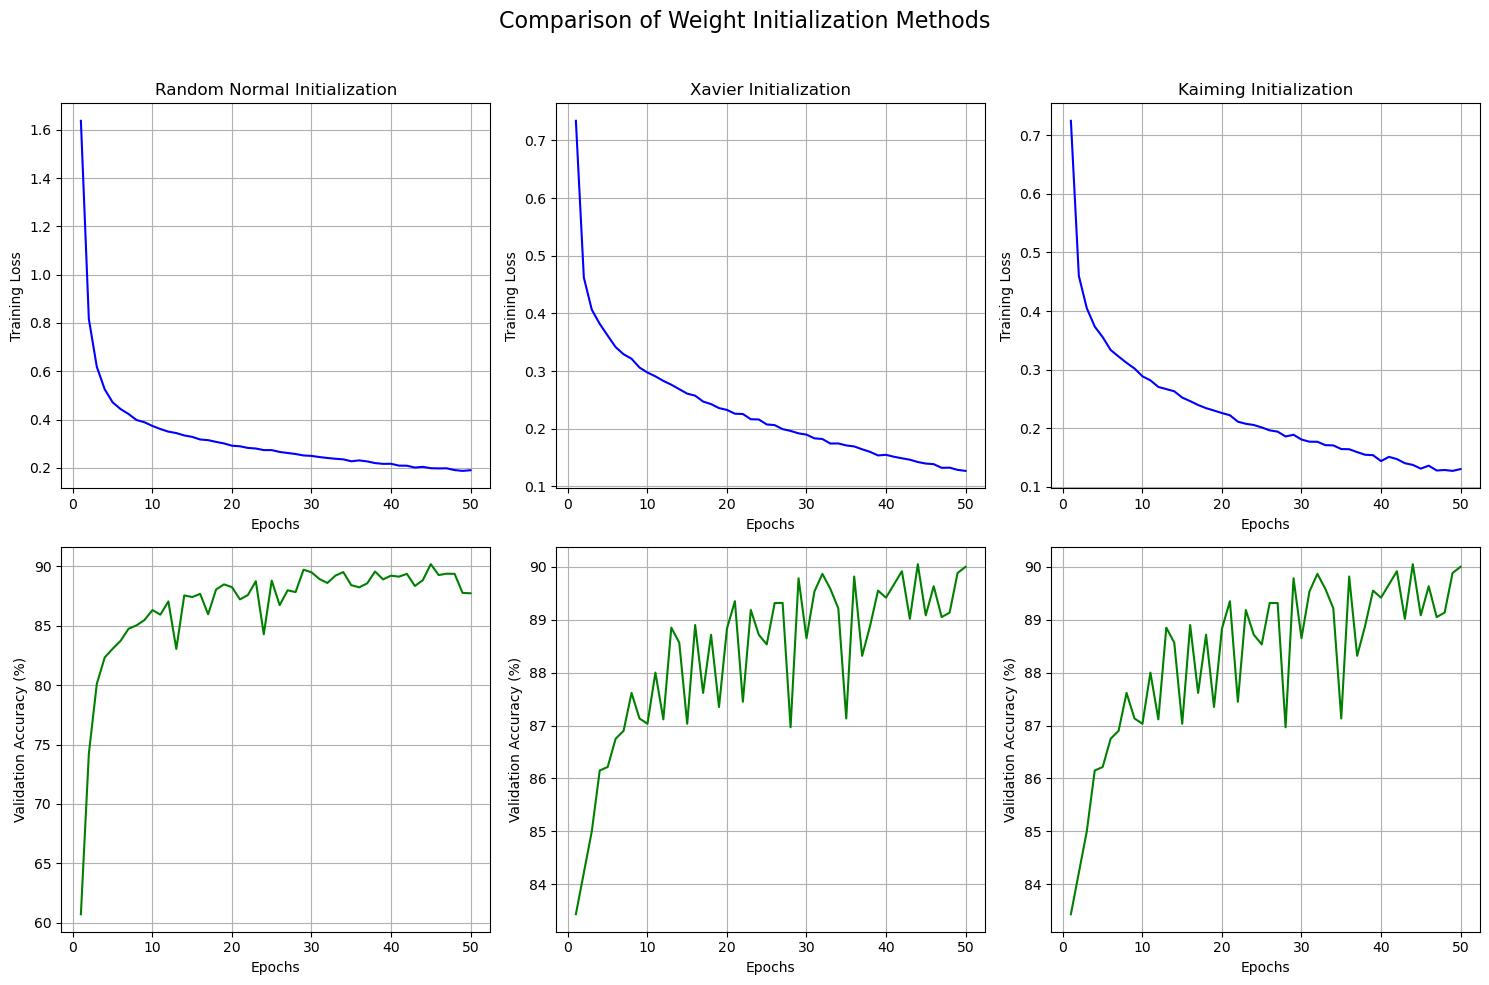

In [96]:
results = {
    "random_normal": {
        "train_loss": rn_train_loss, 
        "val_accuracy": rn_val_accuracy,
    },
    "xavier": {
        "train_loss": xavier_train_loss,
        "val_accuracy": xavier_val_accuracy,
    },
    "kaiming": {
        "train_loss": kaiming_train_loss,
        "val_accuracy": xavier_val_accuracy,
    },
}

# Initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparison of Weight Initialization Methods", fontsize=16)

# Titles for each initialization method
methods = ["random_normal", "xavier", "kaiming"]
titles = ["Random Normal Initialization", "Xavier Initialization", "Kaiming Initialization"]

# Plot training loss for each method
for i, method in enumerate(methods):
    train_loss = results[method]["train_loss"]
    val_accuracy = results[method]["val_accuracy"]

    # Training Loss Curve
    axes[0, i].plot(range(1, len(train_loss) + 1), train_loss, label=f"{method} Loss", color="blue")
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xlabel("Epochs")
    axes[0, i].set_ylabel("Training Loss")
    axes[0, i].grid()

    # Validation Accuracy Curve
    axes[1, i].plot(range(1, len(val_accuracy) + 1), val_accuracy, label=f"{method} Accuracy", color="green")
    axes[1, i].set_xlabel("Epochs")
    axes[1, i].set_ylabel("Validation Accuracy (%)")
    axes[1, i].grid()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# Save the figure as a PDF 
plt.savefig("Weight_Initialization_Comparison.pdf")

# Show the plot
plt.show()


In [98]:
class ACAIGFCNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(ACAIGFCNWithBatchNorm, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.BatchNorm1d(hidden_layers[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(nn.BatchNorm1d(hidden_layers[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

100%|██████████| 50/50 [02:20<00:00,  2.81s/it]


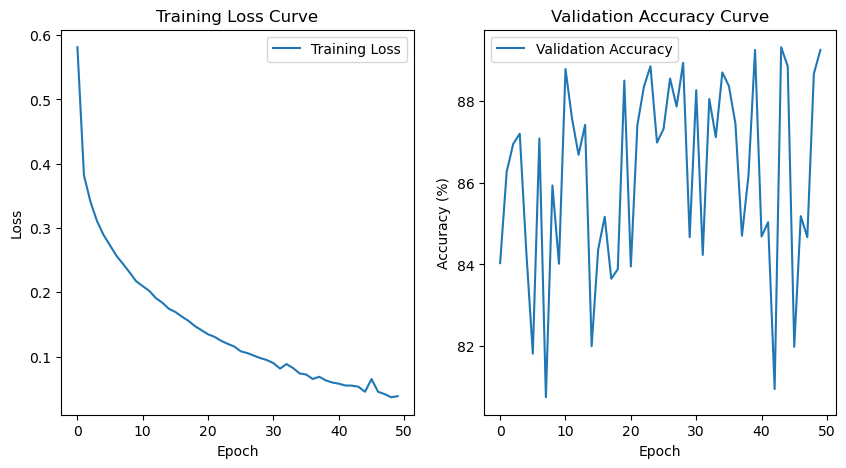

In [103]:
# Define model parameters
input_dim = 784
output_dim = 10
hidden_layers = [256, 128]
epochs = 50
learning_rate = 0.1

# Initialize model, loss function, and optimizer
model = ACAIGFCNWithBatchNorm(input_dim, output_dim, hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and validate
train_loss, val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("Batch_Norm.pdf")

plt.show()

In [100]:
calculate_test_accuracy(model)

Mean Accuracy on Test Set: 87.19%
Standard Deviation of Accuracy Across Batches: 2.59%


In [105]:
class ACAIGFCNWithDropoutAndBatchNorm(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout_prob=0.5):
        super(ACAIGFCNWithDropoutAndBatchNorm, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.BatchNorm1d(hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(nn.BatchNorm1d(hidden_layers[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:46<00:00,  2.87s/it]


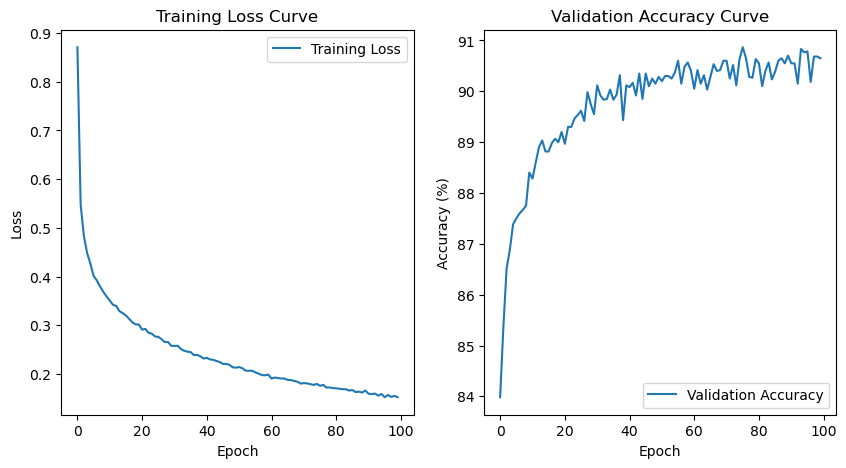

Mean Accuracy on Test Set: 89.49%
Standard Deviation of Accuracy Across Batches: 2.36%


In [106]:
# Define model parameters
input_dim = 784
output_dim = 10
hidden_layers = [256, 128]
epochs = 100
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = ACAIGFCNWithDropoutAndBatchNorm(input_dim, output_dim, hidden_layers)
initialize_weights(model, "xavier")
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and validate
train_loss, val_accuracy = train_and_validate(model, loss_func, optimizer, epochs)

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()

# Save the figure as a PDF 
plt.savefig("bonus_plots.pdf")

plt.show()

calculate_test_accuracy(model)

In [112]:
import zipfile
import os

# Define the paths
notebook_name = "amath_482_hw4.ipynb"  
output_zip_name = "amath_482_hw4.zip" 

# Initialize a ZipFile object
with zipfile.ZipFile(output_zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add the notebook
    zipf.write(notebook_name)
    
    for file_name in os.listdir():
        if file_name != notebook_name and not file_name.endswith('.zip'):
            zipf.write(file_name)

print(f"Notebook and files zipped into: {output_zip_name}")

Notebook and files zipped into: amath_482_hw4.zip
